In [1]:
%load_ext autoreload
%autoreload 2

import logging

import helpers.dbg as dbg
import helpers.printing as prnt

prnt.config_notebook()

#dbg.init_logger(verbosity=logging.DEBUG)
dbg.init_logger(verbosity=logging.INFO)
# dbg.test_logger()
_LOG = logging.getLogger(__name__)

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-6728fe92-8743-4b7e-a75e-1e8c61ec2f69.json'


In [2]:
_LOG.debug = _LOG.info

# Generate random data

In [26]:
import numpy as np
import pandas as pd
import core.dataflow_model.pnl as pnl

df = pnl.compute_data(21)

# np.random.seed(42)

# #date_range = pd.date_range("09:30", "15:00", freq="1T")
# date_range = pd.date_range("09:30", "10:00", freq="1T")

# diff = np.random.normal(0, 1, size=len(date_range))
# diff = diff.cumsum()
# price = 100.0 + diff
# df = pd.DataFrame(price, index=date_range, columns=["price"])

# # ask, bid
# df["ask"] = price + np.abs(np.random.normal(0, 1, size=len(date_range)))
# df["bid"] = price - np.abs(np.random.normal(0, 1, size=len(date_range)))
#display(df)
display(df.head(3))
display(df.tail(3))

,price,ask,bid
2021-09-09 09:30:00,100.496714,100.722490,100.381066
2021-09-09 09:31:00,100.358450,100.425978,100.057346
2021-09-09 09:32:00,101.006138,102.430887,99.527616


,price,ask,bid
2021-09-09 09:48:00,97.986332,98.183194,97.507158
2021-09-09 09:49:00,96.574029,97.312495,96.388370
2021-09-09 09:50:00,98.039678,98.211046,96.933343


## Case 1: instantaneous, no costs

In [31]:
# Sample on 5 minute bars labeling and close on the right

# df_5mins = df.resample("5T", closed="right", label="right").last()
    
# df_5mins["ret_0"] = df_5mins["price"].pct_change()

# np.random.seed(42)
# df_5mins["preds"] = (np.random.random(df_5mins.shape[0]) >= 0.5) * 2.0 - 1.0

mode = "instantaneous"
df_5mins = pnl.resample_data(df, mode)
display(df_5mins)

,price,ask,bid,ret_0,preds
2021-09-09 09:30:00,100.496714,100.722490,100.381066,NaN,-1.0
2021-09-09 09:35:00,102.060878,103.211871,101.003756,0.015564,1.0
2021-09-09 09:40:00,104.017193,105.869472,103.340271,0.019168,1.0
2021-09-09 09:45:00,99.592940,99.801804,99.283728,-0.042534,0.0
2021-09-09 09:50:00,98.039678,98.211046,96.933343,-0.015596,0.0


<AxesSubplot:>

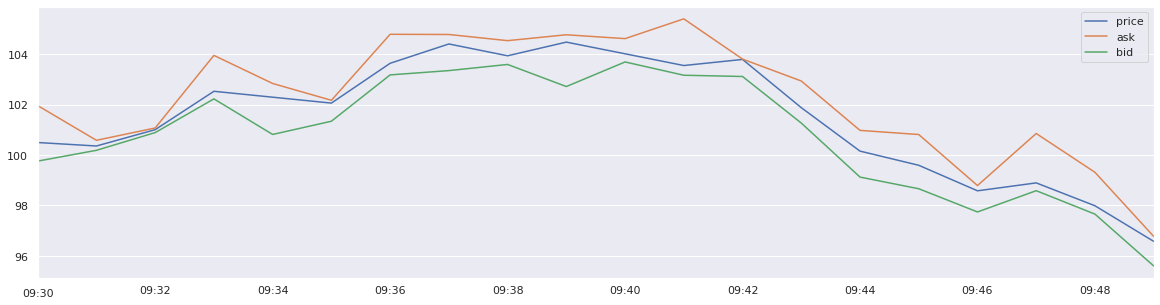

In [19]:
df.plot()

In [35]:
w0 = 100.0
final_w, tot_ret = pnl.compute_pnl_for_instantaneous_no_cost_case(w0, df, df_5mins)

print(final_w, tot_ret)

ts=2021-09-09 09:30:00
# pred=-1.0 price_5=102.06087791467625 price_10=104.0171934241751
  w=100.0 num_shares=0.9798073663799055
  diff=-1.9168123471702359 -> w=98.08318765282976
ts=2021-09-09 09:35:00
# pred=1.0 price_5=104.0171934241751 price_10=99.59294033575907
  w=98.08318765282976 num_shares=0.9429516835053714
  diff=-4.1718568979757435 -> w=93.91133075485402
ts=2021-09-09 09:40:00
# pred=1.0 price_5=99.59294033575907 price_10=98.03967754008498
  w=93.91133075485402 num_shares=0.9429516835053714
  diff=-1.4646517681071458 -> w=92.44667898674687
92.44667898674687 -0.07553321013253125


In [43]:
# Use lags.
df_5mins["pnl"] = df_5mins["preds"] * df_5mins["ret_0"].shift(-2)
pnls = df_5mins["pnl"]

tot_ret2 = (1 + pnls).prod() - 1

print("tot_ret=", tot_ret)
print("tot_ret2=", tot_ret2)

np.testing.assert_almost_equal(tot_ret, tot_ret2)
display(df_5mins[:-1])

tot_ret= -0.07553321013253125
tot_ret2= -0.07552321013253112


AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: -0.07553321013253125
 DESIRED: -0.07552321013253112

In [10]:
# Show that the previous approach (which trades two times per interval) is equivalent to trading once with the
# sum of the position.

orders = []

for ts, row in df_5mins[:-2].iterrows():
    _LOG.debug("ts=%s", ts)
    pred = row["preds"]
    if pred == 1:
        # Go long.
        action_5 = "buy"
        action_10 = "sell"
    elif pred == -1:
        # Short sell.
        action_5 = "sell"
        action_10 = "buy"
    else:
        raise ValueError
    order = (ts + pd.DateOffset(minutes=5), action_5)
    print(order)
    orders.append(order)
    order = (ts + pd.DateOffset(minutes=10), action_10)
    print(order)
    orders.append(order)
    
w0 = 100.0

def compute_pnl_from_orders(orders):
    # Assume the orders are in chronological order.
    holdings = 0.0
    cash = w0
    for order in orders:
        ts, action = order
        _LOG.debug("# ts=%s action=%s", ts, action)
        price = df.loc[ts]["price"]
        _LOG.debug("  price=%s", price)
        # 
        wealth = holdings * price + cash
        _LOG.debug("  before: cash=%s holdings=%s wealth=%s", cash, holdings, wealth)
        # Assume that we invest always all the wealth.
        num_shares = wealth / price
        if action == "buy":
            cash -= num_shares * price
            holdings += num_shares
        elif action == "sell":
            cash += num_shares * price
            holdings -= num_shares
        else:
            raise ValueError
        _LOG.debug("  after: cash=%s holdings=%s wealth=%s", cash, holdings, wealth)
    # We don't necessary liquidate the portfolio.
    return holdings * price + cash


w = compute_pnl_from_orders(orders)
print((w - w0) / w0)


ts=2021-09-08 09:30:00
(Timestamp('2021-09-08 09:35:00', freq='5T'), 'sell')
(Timestamp('2021-09-08 09:40:00', freq='5T'), 'buy')
ts=2021-09-08 09:35:00
(Timestamp('2021-09-08 09:40:00', freq='5T'), 'buy')
(Timestamp('2021-09-08 09:45:00', freq='5T'), 'sell')
ts=2021-09-08 09:40:00
(Timestamp('2021-09-08 09:45:00', freq='5T'), 'buy')
(Timestamp('2021-09-08 09:50:00', freq='5T'), 'sell')
ts=2021-09-08 09:45:00
(Timestamp('2021-09-08 09:50:00', freq='5T'), 'buy')
(Timestamp('2021-09-08 09:55:00', freq='5T'), 'sell')
ts=2021-09-08 09:50:00
(Timestamp('2021-09-08 09:55:00', freq='5T'), 'sell')
(Timestamp('2021-09-08 10:00:00', freq='5T'), 'buy')
# ts=2021-09-08 09:35:00 action=sell
  price=102.06087791467625
  before: cash=100.0 holdings=0.0 wealth=100.0
  after: cash=200.0 holdings=-0.9798073663799055 wealth=100.0
# ts=2021-09-08 09:40:00 action=buy
  price=104.0171934241751
  before: cash=200.0 holdings=-0.9798073663799055 wealth=98.08318765282976
  after: cash=101.91681234717024 holding

In [ ]:
## Case 2: interval trading, no costs

In [7]:
df_5mins = df.resample("5T", closed="right", label="right").mean()

if True:
    a = df.iloc[1:6]["price"].mean()
    b = df_5mins.iloc[1]["price"]
    #print(a, b)
    assert a == b
    
df_5mins["ret_0"] = df_5mins["price"].pct_change()

np.random.seed(42)
df_5mins["preds"] = (np.random.random(df_5mins.shape[0]) >= 0.5) * 2.0 - 1.0
display(df_5mins)

,price,ask,bid,ret_0,preds
2021-09-08 09:30:00,100.496714,102.348992,99.390379,NaN,-1.0
2021-09-08 09:35:00,101.649930,102.314622,100.761827,0.011475,1.0
2021-09-08 09:40:00,104.096694,104.975605,103.508292,0.024070,1.0
2021-09-08 09:45:00,101.794641,102.409792,100.716172,-0.022115,1.0
2021-09-08 09:50:00,98.014901,98.789490,97.188099,-0.037131,-1.0
2021-09-08 09:55:00,96.817506,97.635525,96.202972,-0.012216,-1.0
2021-09-08 10:00:00,94.575384,95.031555,94.013223,-0.023158,-1.0
